# Adaptive Propagation Graph Convolutional Network (AP-GCN) With some Graphs

## 1. Setup and Installation

Colab uses by default a pytorch version 2.6.0 + cu241 but the problem is that the latest version of torch scatter and sparse that are compatible with torch is 2.5.1 and 2.5.0. Therefore, i need to go back in version.

In [1]:
import torch
print(f"Current PyTorch version: {torch.__version__}")
print(f"Current CUDA version: {torch.version.cuda}")

!pip uninstall -y torch torchvision torchaudio
# PyTorch 2.5.0 with CUDA 12.4
!pip install torch==2.5.0+cu124 torchvision==0.20.0+cu124 torchaudio==2.5.0+cu124 --index-url https://download.pytorch.org/whl/cu124
# now geometric stuff
#need ro restart session

Current PyTorch version: 2.6.0+cu124
Current CUDA version: 12.4
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 M

In [1]:
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install torch-geometric
!pip install matplotlib seaborn PyYAML tqdm

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00


In [2]:
import torch
print(f"Current PyTorch version: {torch.__version__}")
print(f"Current CUDA version: {torch.version.cuda}")

Current PyTorch version: 2.5.0+cu124
Current CUDA version: 12.4


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import ModuleList, Dropout, ReLU, Linear
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import dropout_adj, to_networkx, degree, remove_self_loops, dropout_edge
from torch_geometric.utils import add_self_loops as add_self_loops_fn
from torch_geometric.data import Data, InMemoryDataset
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparse_sum, mul
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap, Normalize
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from matplotlib.cm import ScalarMappable
import os
import time
from typing import List

# seed plus gpu setting.
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. AP-GCN Implementation

We'll implement the AP-GCN using the authors approach and subtleties of the implementation actually done

In [4]:
class AdaptivePropagation(MessagePassing):
    def __init__(self, niter: int, h_size: int, bias = True, **kwargs):
        """
        Adaptive propagation layer.

        niter: max number of propagation steps (T in the paper)
        h_size: size of the node embeddings
        bias: if to add a bias in the halting unit
        """
        super(AdaptivePropagation, self).__init__(aggr='add', **kwargs)

        self.niter = niter
        self.halt = Linear(h_size, 1) # halting unit (Q and q in equation 6)

        self.reg_params = list(self.halt.parameters()) #halting params
        self.dropout = Dropout()

        # normalization params for the GCN layer norm they do in their code, needed to adapt for the new version.
        self.improved = False
        self.add_self_loops = True

        # init params
        self.reset_parameters()

    def reset_parameters(self):
        """
        bias around 1/n+1 -> check my paper comments. it is easy to show that after passing
        through the sigmoid, we get that the probability takes a value around 1/n+1
        """
        self.halt.reset_parameters()

        x = (self.niter+1) // 1
        b = math.log((1/x)/(1-(1/x)))
        self.halt.bias.data.fill_(b)

    def forward(self, local_preds: torch.FloatTensor, edge_index):
        """
        local_preds: node embeddings from local prediction network
        edge_index: graph connectivity in COO format

        returns:
            Updated node embeddings, number of steps, and remainders
        """
        sz = local_preds.size(0) #num of nodes.

        steps = torch.ones(sz).to(local_preds.device)  # steps for each node (K_i)
        sum_h = torch.zeros(sz).to(local_preds.device)  # accum halting probs
        continue_mask = torch.ones(sz, dtype=torch.bool).to(local_preds.device)  # active nodes
        x = torch.zeros_like(local_preds).to(local_preds.device)  # embeddings

        # dropout of embedding.
        prop = self.dropout(local_preds)

        # propagation loop
        for _ in range(self.niter):
            old_prop = prop #h^(t-1)

            continue_fmask = continue_mask.float().to(local_preds.device)
            drop_edge_index, _ = dropout_edge(edge_index, p=0.5, training=self.training) #default is 0.5 as they did.

            # GCN normalization using the util that is now available.  -> https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gcn_conv.html#GCNConv
            edge_index_norm, norm = gcn_norm(
                drop_edge_index, None,
                sz, self.improved,
                self.add_self_loops,
                self.flow, local_preds.dtype
            )

            prop = self.propagate(edge_index_norm, x=prop, norm=norm)
            h = torch.sigmoid(self.halt(prop)).t().squeeze() # h^k_i = non-linearity(Qz^k_i + q)

            # here we do the soft update based on equation 7
            # K_i = min{k : sum(j=1 to k) h^j_i >= 1 - eps}
            # 0.99 is equivalent to (1 - eps) where eps = 0.01
            prob_mask = (((sum_h+h) < 0.99) & continue_mask).squeeze()
            prob_fmask = prob_mask.float().to(local_preds.device)

            # we add another step for those nodes that continue and that the accum prob is lower than threshold.
            steps = steps + prob_fmask
            sum_h = sum_h + prob_fmask * h #and update the accumulation for those nodes that continue  (otherwise the prob mask takes 0 so no update. )

            final_iter = steps < self.niter

            # if mask prob is 1 means that need to continue + did not reach the end so continue.
            condition = prob_mask & final_iter
            p = torch.where(condition, sum_h, 1-sum_h) #p^k_i according to equation 8

            # this is something they did in the code too.
            to_update = self.dropout(continue_fmask).unsqueeze(1)

            # equation 9 -> softupdate.
            # z'_i = (1/K_i) * sum(k=1 to K_i) p^k_i * z^k_i + (1-p^k_i) * z^(k-1)_i
            x = x + (prop * p.unsqueeze(1) + old_prop * (1-p).unsqueeze(1)) * to_update
            continue_mask = continue_mask & prob_mask

            # if all nodes halted, then stop.
            if (~continue_mask).all():
                break

        # continueation of the equation 9 (1/K_i)
        x = x / steps.unsqueeze(1)

        # updated embeddings, steps, and  R_i
        return x, steps, (1-sum_h)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class APGCN(torch.nn.Module):
    """
    Adaptive Propagation Graph Convolutional Network.
    """
    def __init__(self,
                 dataset,
                 niter=10,
                 prop_penalty=0.005,
                 hidden=[64],
                 dropout=0.5):
        """
        dataset: The graph dataset
        niter: Maximum number of propagation steps
        prop_penalty: Propagation penalty α in equation 11
        hidden: List of hidden layer sizes
        dropout: Dropout rate
        """
        super(APGCN, self).__init__()

        num_features = [dataset.data.x.shape[1]] + hidden + [dataset.num_classes] # layer sizes.

        # as authors did, we create the mlp before prop.
        layers = []
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            layers.append(Linear(in_features, out_features))

        # we do the propagation with the previous format.
        self.prop = AdaptivePropagation(niter, dataset.num_classes)

        self.prop_penalty = prop_penalty # alpha

        self.layers = ModuleList(layers) #mlp

        # we separate parameters into regularized and non-regularized groups -> they did this in their code.
        self.reg_params = list(layers[0].parameters())
        self.non_reg_params = list([p for l in layers[1:] for p in l.parameters()])
        self.dropout = Dropout(p=dropout)
        self.act_fn = ReLU()

        self.reset_parameters()

    def reset_parameters(self):
        self.prop.reset_parameters()
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, data, return_propagation_cost=False):
        """
        data: PyG data object containing x and edge_index
        return_propagation_cost: Whether to return the propagation cost

        returns:
            Log probabilities, number of steps, and remainders
        """
        x, edge_index = data.x, data.edge_index

        # MLP
        for i, layer in enumerate(self.layers):
            x = layer(self.dropout(x))

            #no non linearity in the last layer.
            if i == len(self.layers) - 1:
                break

            x = self.act_fn(x)

        # the adaptive propagation.
        x, steps, reminders = self.prop(x, edge_index)

        # log probabilities, steps, and remainders
        if return_propagation_cost:
            return torch.nn.functional.log_softmax(x, dim=1), steps, reminders
        return torch.nn.functional.log_softmax(x, dim=1), steps, reminders

## 3. Training and Evaluation Functions

In [5]:
def train(model, data, optimizer, train_halt=True, weight_decay=0.008):
    """
    model: The AP-GCN model
    data: data object
    optimizer
    train_halt: if to train the halting unit in this epoch
    weight_decay: L2 regularization strength
    Returns:
        Training loss, average propagation steps
    """
    model.train()

    # the authors do this by optimizing each 5 epochs.
    for param in model.prop.parameters():
        param.requires_grad = train_halt

    optimizer.zero_grad()

    logits, steps, reminders = model(data)


    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask]) # task loss
    l2_reg = sum((torch.sum(param ** 2) for param in model.reg_params)) # the l2 reg as they did

    #FINAL LOSS EXPRESSION
    loss += weight_decay/2 * l2_reg + model.prop_penalty * (steps[data.train_mask] + reminders[data.train_mask]).mean()

    # backprop
    loss.backward()
    optimizer.step()

    return loss.item(), (steps + reminders).mean().item()


def evaluate(model, data, mask=None):
    model.eval()
    with torch.no_grad():
        logits, steps, reminders = model(data)

        # just in case we dont have we assign all to evaluate but all this datasets brings their own masks.
        if mask is None:
            mask = torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)

        pred = logits[mask].max(1)[1]

        # accuracy
        correct = pred.eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        acc = correct / total if total > 0 else 0

        # average propagation steps
        prop_cost = steps + reminders
        avg_steps = prop_cost[mask].mean().item() if mask.sum() > 0 else 0

    return acc, avg_steps

## 4. Visualization Functions

visualize the ponder time distribution and how it relates to graph structure.

In [6]:
def visualize_propagation_steps(model, data, dataset_name):
    """Allow us to visualize the distribution of propagation steps per node."""
    model.eval()

    with torch.no_grad():
        # popagation steps per node
        logits, steps, remainders = model(data)
        prop_cost = steps + remainders

        steps_np = steps.cpu().numpy()
        remainders_np = remainders.cpu().numpy()
        prop_cost_np = prop_cost.cpu().numpy()

        # PLOTS.
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Plot 1: Steps histogram
        axes[0].hist(steps_np, bins=range(1, int(steps_np.max()) + 2), alpha=0.7, color='blue', rwidth=0.8)
        axes[0].set_title('Distribution of Integer Steps (K_i)')
        axes[0].set_xlabel('Number of Steps')
        axes[0].set_ylabel('Count')
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Remainders histogram
        axes[1].hist(remainders_np, bins=20, alpha=0.7, color='green', rwidth=0.8)
        axes[1].set_title('Distribution of Remainders (R_i)')
        axes[1].set_xlabel('Remainder Value')
        axes[1].set_ylabel('Count')
        axes[1].grid(True, alpha=0.3)

        # Plot 3: Total propagation cost
        axes[2].hist(prop_cost_np, bins=20, alpha=0.7, color='red', rwidth=0.8)
        axes[2].set_title('Distribution of Propagation Cost (S_i = K_i + R_i)')
        axes[2].set_xlabel('Propagation Cost')
        axes[2].set_ylabel('Count')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'propagation_distribution_{dataset_name}.png', dpi=300)
        plt.show()

        # statistics
        print(f"Steps statistics:")
        print(f"  Average: {steps_np.mean():.2f} ± {steps_np.std():.2f}")
        print(f"  Min: {steps_np.min():.2f}, Max: {steps_np.max():.2f}")
        print(f"Remainder statistics:")
        print(f"  Average: {remainders_np.mean():.2f} ± {remainders_np.std():.2f}")
        print(f"Total propagation cost:")
        print(f"  Average: {prop_cost_np.mean():.2f} ± {prop_cost_np.std():.2f}")
        print(f"  Min: {prop_cost_np.min():.2f}, Max: {prop_cost_np.max():.2f}")

In [7]:
def visualize_propagation_heatmap(model, data, dataset_name, save_dir='./visualizations'):
    """heatmap visualization of propagation steps across nodes based on centrality"""
    os.makedirs(save_dir, exist_ok=True)

    model.eval()

    with torch.no_grad():
        # propagation steps and remainders
        logits, steps, remainders = model(data)
        prop_cost = steps + remainders

        steps_np = steps.cpu().numpy()
        remainders_np = remainders.cpu().numpy()

        # to plot the graph.
        G = to_networkx(data, to_undirected=True)

        # we compute node centrality:
        try:
            centrality = nx.betweenness_centrality(G)
            nodes_by_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
            node_order = [node for node, _ in nodes_by_centrality]
        except:
            node_order = list(range(len(G.nodes())))

        max_steps = int(np.max(steps_np))
        step_matrix = np.zeros((len(node_order), max_steps))
        for i, node_idx in enumerate(node_order):
            step = int(steps_np[node_idx])
            rem = remainders_np[node_idx]


            for j in range(step):
                step_matrix[i, j] = 1.0  # assign the step if we did the complete step.

            # remiinder for the final step
            if step < max_steps:
                step_matrix[i, step-1] = rem  # and the reminder for the left part.


        plt.figure(figsize=(12, 10))
        sns.heatmap(step_matrix, cmap='viridis', cbar_kws={'label': 'Propagation Probability'})
        plt.title(f'Propagation Heatmap for {dataset_name} Dataset\n(Nodes ordered by centrality)')
        plt.xlabel('Propagation Step')
        plt.ylabel('Node Index (by centrality)')
        plt.tight_layout()
        plt.savefig(f'{save_dir}/prop_heatmap_{dataset_name}.png', dpi=300)
        plt.show()

In [8]:
def visualize_node_degree_vs_steps(model, data, dataset_name, save_dir='./visualizations'):
    """relationship between node degree and propagation steps"""
    os.makedirs(save_dir, exist_ok=True)

    model.eval()

    with torch.no_grad():
        logits, steps, remainders = model(data)
        prop_cost = steps + remainders

        steps_np = steps.cpu().numpy()
        prop_cost_np = prop_cost.cpu().numpy()

        # we calculate the nodes degree
        node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).cpu().numpy()


        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        jitter = np.random.normal(0, 0.1, size=steps_np.shape)

        # Plot 1: Degree vs integer steps
        scatter1 = axes[0].scatter(node_degrees, steps_np + jitter,
                                  c=node_degrees, cmap='viridis', alpha=0.7, s=50)

        # trend
        z1 = np.polyfit(node_degrees, steps_np, 1)
        p1 = np.poly1d(z1)
        x_range = np.linspace(min(node_degrees), max(node_degrees), 100)
        axes[0].plot(x_range, p1(x_range), 'r--', linewidth=2)

        # correlation coefficient.
        corr1 = np.corrcoef(node_degrees, steps_np)[0, 1]
        axes[0].annotate(f'Correlation: {corr1:.2f}',
                         xy=(0.05, 0.95), xycoords='axes fraction',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        axes[0].set_title('Node Degree vs. Integer Steps (K_i)')
        axes[0].set_xlabel('Node Degree')
        axes[0].set_ylabel('Number of Steps')
        fig.colorbar(scatter1, ax=axes[0], label='Node Degree')
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Degree vs total propagation cost
        scatter2 = axes[1].scatter(node_degrees, prop_cost_np + jitter,
                                  c=node_degrees, cmap='viridis', alpha=0.7, s=50)

        # trend
        z2 = np.polyfit(node_degrees, prop_cost_np, 1)
        p2 = np.poly1d(z2)
        axes[1].plot(x_range, p2(x_range), 'r--', linewidth=2)

        # correlation coefficient.
        corr2 = np.corrcoef(node_degrees, prop_cost_np)[0, 1]
        axes[1].annotate(f'Correlation: {corr2:.2f}',
                         xy=(0.05, 0.95), xycoords='axes fraction',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        axes[1].set_title('Node Degree vs. Propagation Cost (S_i)')
        axes[1].set_xlabel('Node Degree')
        axes[1].set_ylabel('Propagation Cost')
        fig.colorbar(scatter2, ax=axes[1], label='Node Degree')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{save_dir}/degree_vs_steps_{dataset_name}.png', dpi=300)
        plt.show()

        # the final correlations
        print(f"Correlation between node degree and steps: {corr1:.4f}")
        print(f"Correlation between node degree and propagation cost: {corr2:.4f}")

        # histogram grouped by class.
        if hasattr(data, 'y'):
            labels = data.y.cpu().numpy()
            num_classes = len(np.unique(labels))

            plt.figure(figsize=(12, 6))

            bins = np.linspace(prop_cost_np.min(), prop_cost_np.max(), 20)
            for i in range(num_classes):
                class_steps = prop_cost_np[labels == i]
                if len(class_steps) > 0:
                    plt.hist(class_steps, bins=bins, alpha=0.6,
                            label=f'Class {i}', density=True)

            plt.title(f'Distribution of Propagation Cost by Class for {dataset_name}')
            plt.xlabel('Propagation Cost')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{save_dir}/steps_by_class_{dataset_name}.png', dpi=300)
            plt.show()

In [9]:
def visualize_graph_ponder_time(model, data, dataset_name, max_nodes=1000, save_dir='./visualizations'):
    """graph visualization where nodes are colored by ponder time"""
    os.makedirs(save_dir, exist_ok=True)

    model.eval()

    with torch.no_grad():
        logits, steps, remainders = model(data)
        prop_cost = steps + remainders

        steps_np = steps.cpu().numpy()
        prop_cost_np = prop_cost.cpu().numpy()

        pred = logits.max(1)[1].cpu().numpy()
        G = to_networkx(data, to_undirected=True)

        # constraint to a certain amount of nodes to not take ages.
        if len(G.nodes()) > max_nodes:
            # we take a connected subgraph centered on high-degree nodes
            degrees = dict(G.degree())
            center_node = max(degrees.items(), key=lambda x: x[1])[0]
            subgraph_nodes = list(nx.bfs_tree(G, center_node, depth_limit=3))[:max_nodes]
            G = G.subgraph(subgraph_nodes)

            # steps and predictions for the subgraph
            node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(subgraph_nodes)}
            steps_np = np.array([steps_np[idx] for idx in subgraph_nodes])
            prop_cost_np = np.array([prop_cost_np[idx] for idx in subgraph_nodes])
            pred = np.array([pred[idx] for idx in subgraph_nodes])
            if hasattr(data, 'y'):
                true_labels = np.array([data.y[idx].item() for idx in subgraph_nodes])
        elif hasattr(data, 'y'):
            true_labels = data.y.cpu().numpy()

        #colormap
        cmap = plt.cm.viridis
        norm = Normalize(vmin=prop_cost_np.min(), vmax=prop_cost_np.max())
        node_colors = [cmap(norm(cost)) for cost in prop_cost_np]

        # node size as function of pondering time.
        node_size = 50 + 150 * (prop_cost_np - prop_cost_np.min()) / (prop_cost_np.max() - prop_cost_np.min() + 1e-6)
        try:
            pos = nx.kamada_kawai_layout(G)
        except:
            pos = nx.spring_layout(G, seed=42)

        fig, ax = plt.subplots(figsize=(12, 10))
        nx.draw_networkx_nodes(G, pos,
                              node_color=node_colors,
                              node_size=node_size,
                              alpha=0.8,
                              edgecolors='black',
                              linewidths=0.5,
                              ax=ax)

        nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=ax)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, label='Propagation Cost', ax=ax)

        plt.title(f'Graph Visualization with Ponder Time for {dataset_name}')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'{save_dir}/graph_ponder_time_{dataset_name}.png', dpi=300)
        plt.show()

        # and a visualization with the actual prediction accuracy
        if hasattr(data, 'y'):
            plt.figure(figsize=(12, 10))

            # accuracy
            is_correct = (pred == true_labels)
            node_colors = ['green' if correct else 'red' for correct in is_correct]

            nx.draw_networkx_nodes(G, pos,
                                  node_color=node_colors,
                                  node_size=node_size,
                                  alpha=0.8,
                                  edgecolors='black',
                                  linewidths=0.5)

            nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

            # Add legend
            plt.plot([0], [0], 'o', markersize=10, color='green', label='Correct Prediction')
            plt.plot([0], [0], 'o', markersize=10, color='red', label='Incorrect Prediction')

            plt.title(f'Graph Visualization with Prediction Correctness for {dataset_name}')
            plt.axis('off')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'{save_dir}/graph_prediction_correctness_{dataset_name}.png', dpi=300)
            plt.show()

In [10]:
def visualize_halting_unit(model, data, dataset_name, save_dir='./visualizations'):
    """learned weights and behavior of the halting unit"""
    os.makedirs(save_dir, exist_ok=True)

    model.eval()

    # halting parameters
    weights = model.prop.halt.weight.detach().cpu().numpy()
    bias = model.prop.halt.bias.detach().cpu().item()

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Weight distribution
    axes[0].hist(weights.flatten(), bins=30, alpha=0.7, color='blue')
    axes[0].axvline(x=0, color='r', linestyle='--', label='Zero')
    axes[0].set_title('Halting Unit Weight Distribution')
    axes[0].set_xlabel('Weight Value')
    axes[0].set_ylabel('Count')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2:  halting probabilities by step
    with torch.no_grad():
        # node features
        x, edge_index = data.x, data.edge_index

        # local embeddings (forward pass through layers except propagation)
        for i, layer in enumerate(model.layers):
            x = layer(model.dropout(x))
            if i < len(model.layers) - 1:
                x = model.act_fn(x)


        step_probs = []
        local_preds = x
        sz = local_preds.size(0)

        prop = model.prop.dropout(local_preds)

        edge_index_norm, norm = gcn_norm(
            edge_index, None,
            sz, model.prop.improved,
            model.prop.add_self_loops,
            model.prop.flow, local_preds.dtype
        )

        # simulated prop steps.
        for step in range(1, model.prop.niter + 1):
            prop = model.prop.propagate(edge_index_norm, x=prop, norm=norm)
            #halting prob
            h = torch.sigmoid(model.prop.halt(prop)).mean().item()
            step_probs.append(h)

    # average halting probability by step
    axes[1].plot(range(1, len(step_probs)+1), step_probs, 'o-', color='green', linewidth=2)
    axes[1].set_title('Average Halting Probability by Step')
    axes[1].set_xlabel('Propagation Step')
    axes[1].set_ylabel('Average Halting Probability')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/halting_unit_analysis_{dataset_name}.png', dpi=300)
    plt.show()

    # statistics
    print(f"Halting unit bias: {bias:.4f}")
    print(f"Halting unit weights statistics:")
    print(f"  Mean: {weights.mean():.4f}, Std: {weights.std():.4f}")
    print(f"  Min: {weights.min():.4f}, Max: {weights.max():.4f}")
    print(f"Average halting probabilities by step:")
    for i, prob in enumerate(step_probs):
        print(f"  Step {i+1}: {prob:.4f}")

In [11]:
def run_visualizations(model, data, dataset_name):
    """all visualization functions for the trained model"""
    print("Generating visualizations...")
    os.makedirs('./visualizations', exist_ok=True)
    visualize_propagation_steps(model, data, dataset_name)
    visualize_propagation_heatmap(model, data, dataset_name)
    visualize_node_degree_vs_steps(model, data, dataset_name)
    visualize_graph_ponder_time(model, data, dataset_name)
    visualize_halting_unit(model, data, dataset_name)

    print(f"Visualizations saved in './visualizations' directory")

## 5. Dataset Loading and Training Functions


In [12]:
def load_dataset(dataset_name="Cora"):
    print(f"Loading {dataset_name} dataset...")
    dataset = Planetoid(root=f'./data/{dataset_name}', name=dataset_name, transform=T.NormalizeFeatures())
    data = dataset[0].to(device)

    print(f"Dataset details:")
    print(f"  - Number of nodes: {data.num_nodes}")
    print(f"  - Number of edges: {data.num_edges}")
    print(f"  - Number of features: {data.num_features}")
    print(f"  - Number of classes: {dataset.num_classes}")
    print(f"  - Number of training nodes: {data.train_mask.sum().item()}")
    print(f"  - Number of validation nodes: {data.val_mask.sum().item()}")
    print(f"  - Number of test nodes: {data.test_mask.sum().item()}")

    return dataset, data

In [13]:
def get_hyperparameters(dataset_name):
    """hyperparameters from the paper"""
    # deafult
    params = {
        'hidden': [64],
        'dropout': 0.5,
        'niter': 10,
        'learning_rate': 0.01,
        'weight_decay': 0.008
    }

    # Dataset-specific propagation penalty (α)
    if dataset_name == "Cora":
        params['prop_penalty'] = 0.005
    elif dataset_name == "Citeseer":
        params['prop_penalty'] = 0.001
    elif dataset_name == "PubMed":
        params['prop_penalty'] = 0.001
    elif dataset_name.startswith("amazon"):
        # amazon datasets use weight_decay=0 according to the authors code
        params['weight_decay'] = 0
        params['prop_penalty'] = 0.05
    else:
        # default.
        params['prop_penalty'] = 0.005

    return params

In [14]:
def train_model(dataset, data, hyperparams, epochs=10000, patience=100, halting_step=5):
    """Train the AP-GCN model with early stopping"""
    model = APGCN(
        dataset=dataset,
        niter=hyperparams['niter'],
        prop_penalty=hyperparams['prop_penalty'],
        hidden=hyperparams['hidden'],
        dropout=hyperparams['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=hyperparams['learning_rate']
    )

    #variables
    best_val_acc = 0
    counter = 0
    train_losses = []
    train_steps = []
    val_accs = []
    val_steps = []

    # ponder time evolution checkup for my plots.
    ponder_time_evolution = []
    epoch_to_track = [1, 10, 25, 50, 100, 200, 500]

    print(f"Training AP-GCN with hyperparameters:")
    for key, value in hyperparams.items():
        print(f"  - {key}: {value}")

    for epoch in range(1, epochs + 1):
        # following the authors approach of training the halting unit every 5 epochs
        train_loss, train_step = train(model, data, optimizer, epoch % halting_step == 0, hyperparams['weight_decay'])
        train_losses.append(train_loss)
        train_steps.append(train_step)

        # validation eval
        val_acc, val_step = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)
        val_steps.append(val_step)

        #time pondering.
        if epoch in epoch_to_track:
            with torch.no_grad():
                _, steps, remainders = model(data)
                prop_cost = steps + remainders
                ponder_time_evolution.append((epoch, prop_cost.cpu().numpy()))

        # early stopping :
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), f'best_model_{dataset.name}.pt')
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping after {epoch} epochs.")
            break

        # progress printing.
        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Steps: {train_step:.2f}, Val Acc: {val_acc:.4f}")

    # Testing:
    model.load_state_dict(torch.load(f'best_model_{dataset.name}.pt'))
    test_acc, test_step = evaluate(model, data, data.test_mask)
    print(f"Test Accuracy: {test_acc:.4f}, Avg Steps: {test_step:.2f}")

    # Curves:
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(val_accs)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(train_steps, label='Train')
    plt.plot(val_steps, label='Validation')
    plt.title('Average Propagation Steps')
    plt.xlabel('Epoch')
    plt.ylabel('Steps')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_curves_{dataset.name}.png', dpi=300)
    plt.show()

    return model, ponder_time_evolution

In [15]:
def visualize_ponder_time_training_evolution(ponder_time_evolution, dataset_name):
    """how the ponder time distribution evolves during training"""
    os.makedirs('./visualizations', exist_ok=True)

    epochs = [item[0] for item in ponder_time_evolution]
    all_steps = [item[1] for item in ponder_time_evolution]

    # mean and std evolution
    means = [np.mean(steps) for steps in all_steps]
    stds = [np.std(steps) for steps in all_steps]

    plt.figure(figsize=(10, 6))
    plt.errorbar(epochs, means, yerr=stds, marker='o', capsize=5, linestyle='-', linewidth=2)
    plt.title(f'Evolution of Ponder Time During Training ({dataset_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Average Propagation Steps')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'./visualizations/ponder_time_evolution_{dataset_name}.png', dpi=300)
    plt.show()


    plt.figure(figsize=(12, 8))
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(epochs)))

    # histograms for each epoch
    bins = np.linspace(1, 10, 20)
    for i, (epoch, steps) in enumerate(zip(epochs, all_steps)):
        plt.hist(steps, bins=bins, alpha=0.7, color=colors[i],
                label=f'Epoch {epoch}', density=True, histtype='step', linewidth=2)

    plt.title(f'Distribution of Ponder Time During Training ({dataset_name})')
    plt.xlabel('Propagation Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'./visualizations/ponder_time_distribution_evolution_{dataset_name}.png', dpi=300)
    plt.show()

In [16]:
def main(dataset_name="Cora"):
    """run the complete AP-GCN pipeline"""
    dataset, data = load_dataset(dataset_name)
    hyperparams = get_hyperparameters(dataset_name)

    model, ponder_time_evolution = train_model(dataset, data, hyperparams)   # training

    # PLOTS
    run_visualizations(model, data, dataset_name)
    visualize_ponder_time_training_evolution(ponder_time_evolution, dataset_name)

    return model, data

## 6. Run the Model

Loading Cora dataset...


Processing...
Done!


Dataset details:
  - Number of nodes: 2708
  - Number of edges: 10556
  - Number of features: 1433
  - Number of classes: 7
  - Number of training nodes: 140
  - Number of validation nodes: 500
  - Number of test nodes: 1000
Training AP-GCN with hyperparameters:
  - hidden: [64]
  - dropout: 0.5
  - niter: 10
  - learning_rate: 0.01
  - weight_decay: 0.008
  - prop_penalty: 0.005


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 010, Loss: 2.0036, Steps: 11.10, Val Acc: 0.1620
Epoch: 020, Loss: 1.9851, Steps: 11.04, Val Acc: 0.2080
Epoch: 030, Loss: 1.9614, Steps: 10.39, Val Acc: 0.3820
Epoch: 040, Loss: 1.9179, Steps: 10.51, Val Acc: 0.3360
Epoch: 050, Loss: 1.8890, Steps: 10.68, Val Acc: 0.6960
Epoch: 060, Loss: 1.8380, Steps: 10.33, Val Acc: 0.6880
Epoch: 070, Loss: 1.8532, Steps: 10.63, Val Acc: 0.7140
Epoch: 080, Loss: 1.7172, Steps: 10.01, Val Acc: 0.7580
Epoch: 090, Loss: 1.7234, Steps: 9.31, Val Acc: 0.7700
Epoch: 100, Loss: 1.7200, Steps: 9.21, Val Acc: 0.7760
Epoch: 110, Loss: 1.7399, Steps: 8.39, Val Acc: 0.6980
Epoch: 120, Loss: 1.6924, Steps: 8.43, Val Acc: 0.8000
Epoch: 130, Loss: 1.5690, Steps: 8.67, Val Acc: 0.7980
Epoch: 140, Loss: 1.6521, Steps: 8.39, Val Acc: 0.8040
Epoch: 150, Loss: 1.5981, Steps: 7.94, Val Acc: 0.7960
Epoch: 160, Loss: 1.5319, Steps: 7.20, Val Acc: 0.8000
Epoch: 170, Loss: 1.5420, Steps: 6.49, Val Acc: 0.7820
Epoch: 180, Loss: 1.6015, Steps: 5.59, Val Acc: 0.7320
Ep

<ipython-input-14-f008100b0e78>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{dataset.name}.pt'))


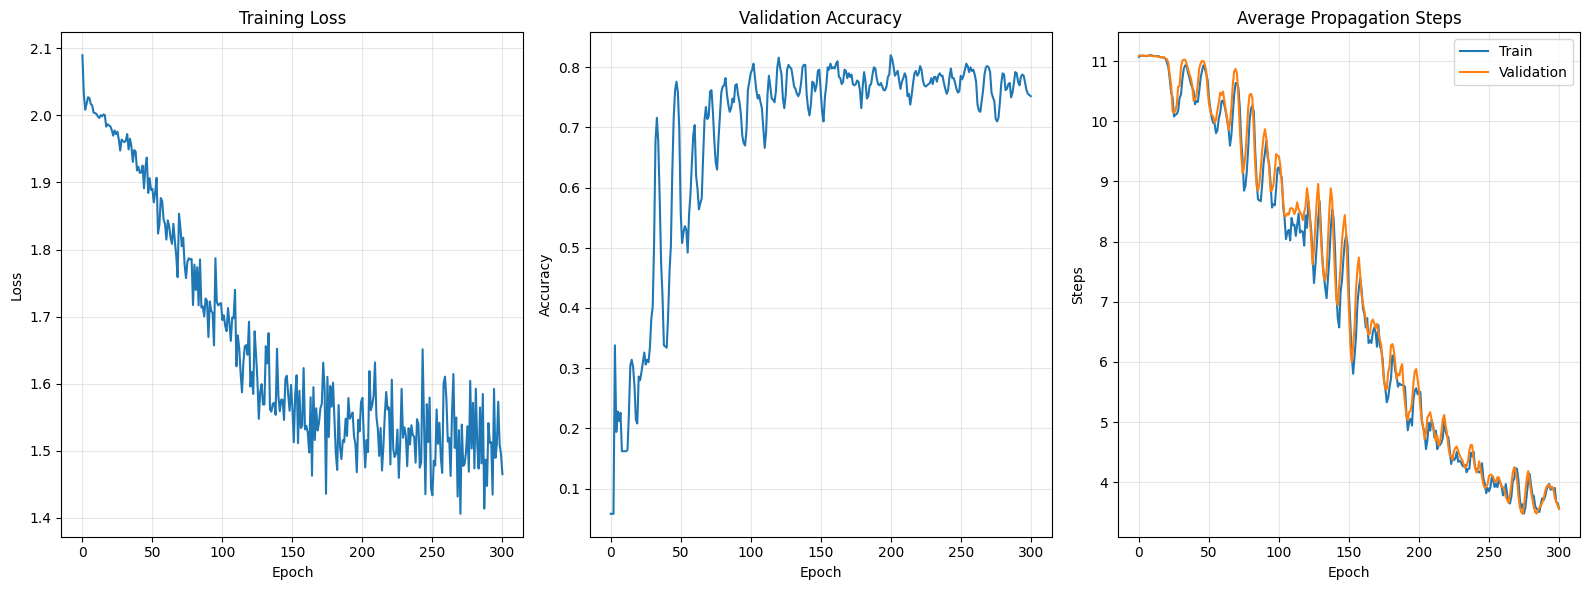

Generating visualizations...


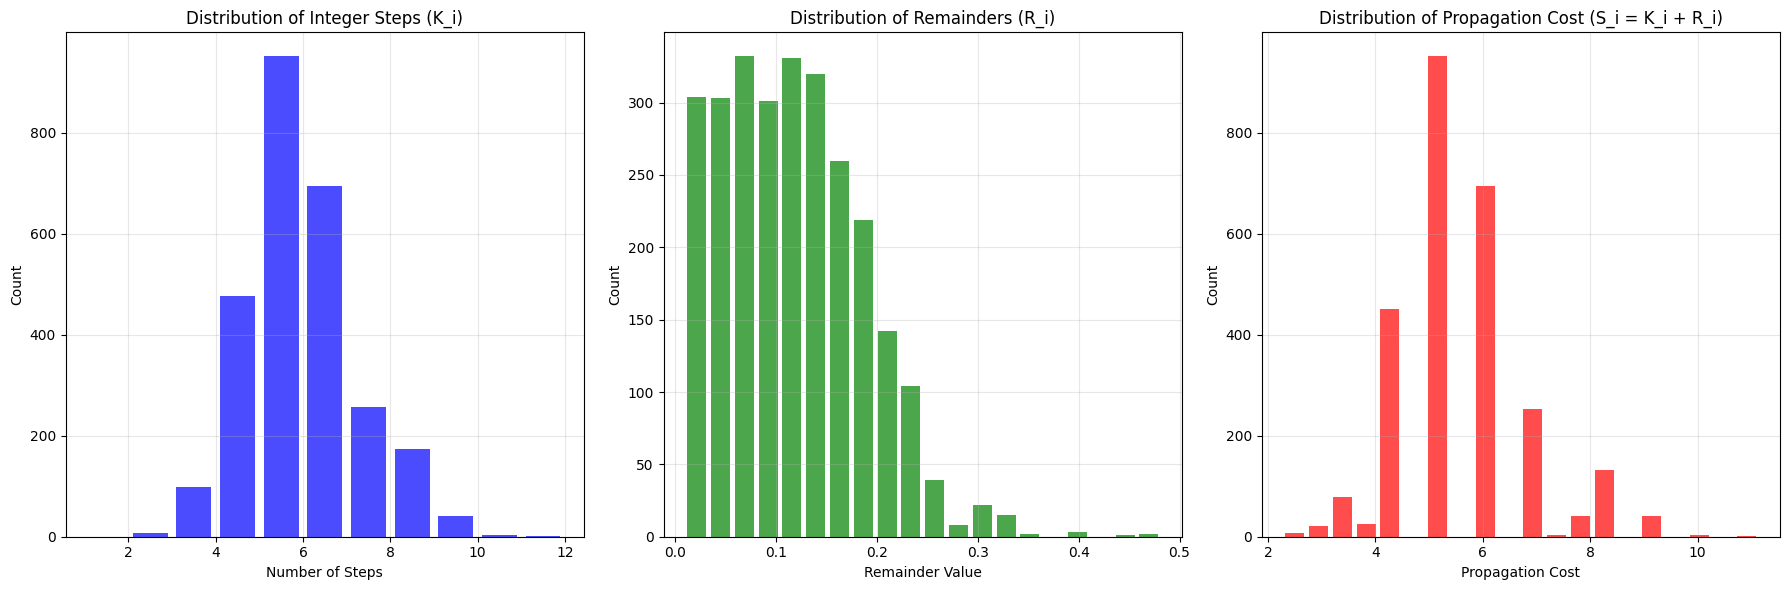

Steps statistics:
  Average: 5.46 ± 1.29
  Min: 2.00, Max: 11.00
Remainder statistics:
  Average: 0.12 ± 0.07
Total propagation cost:
  Average: 5.57 ± 1.26
  Min: 2.27, Max: 11.14


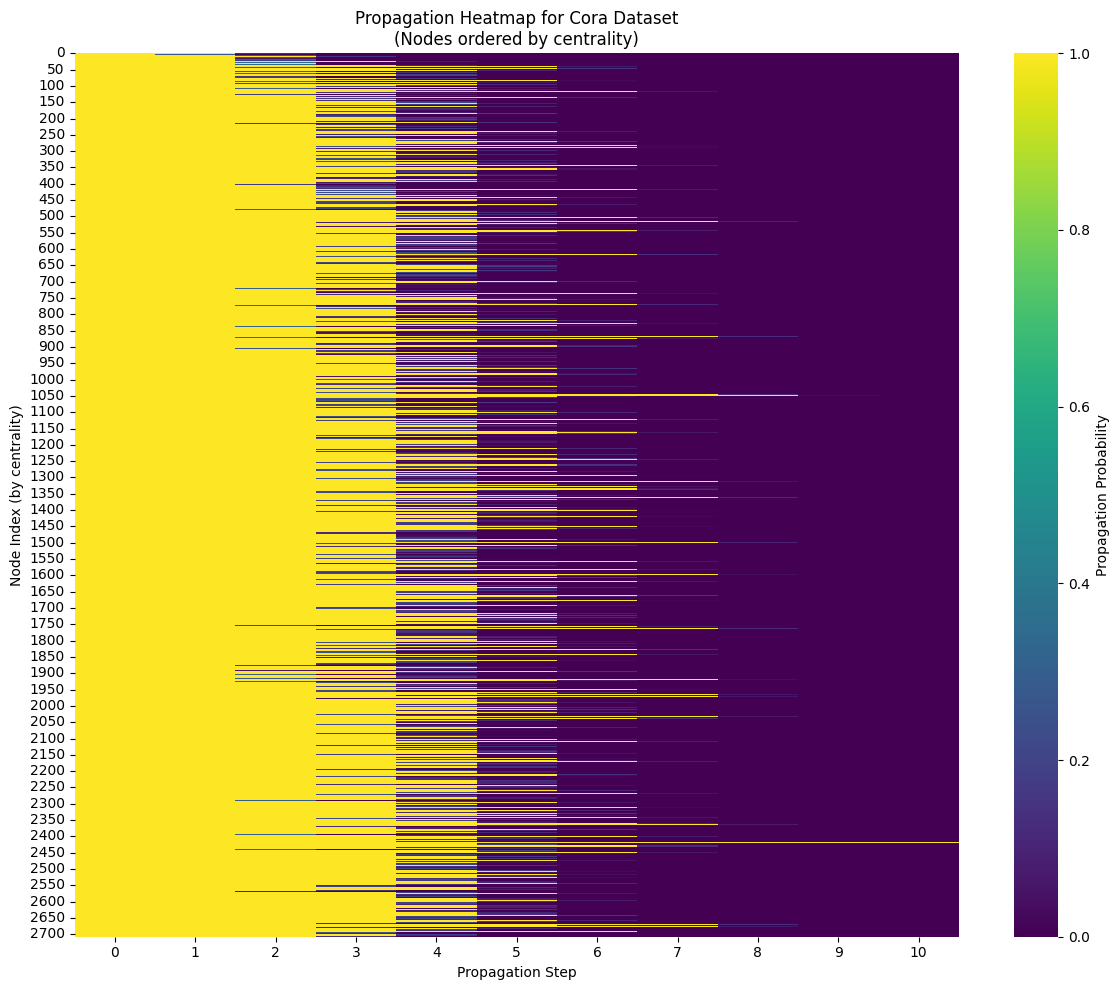

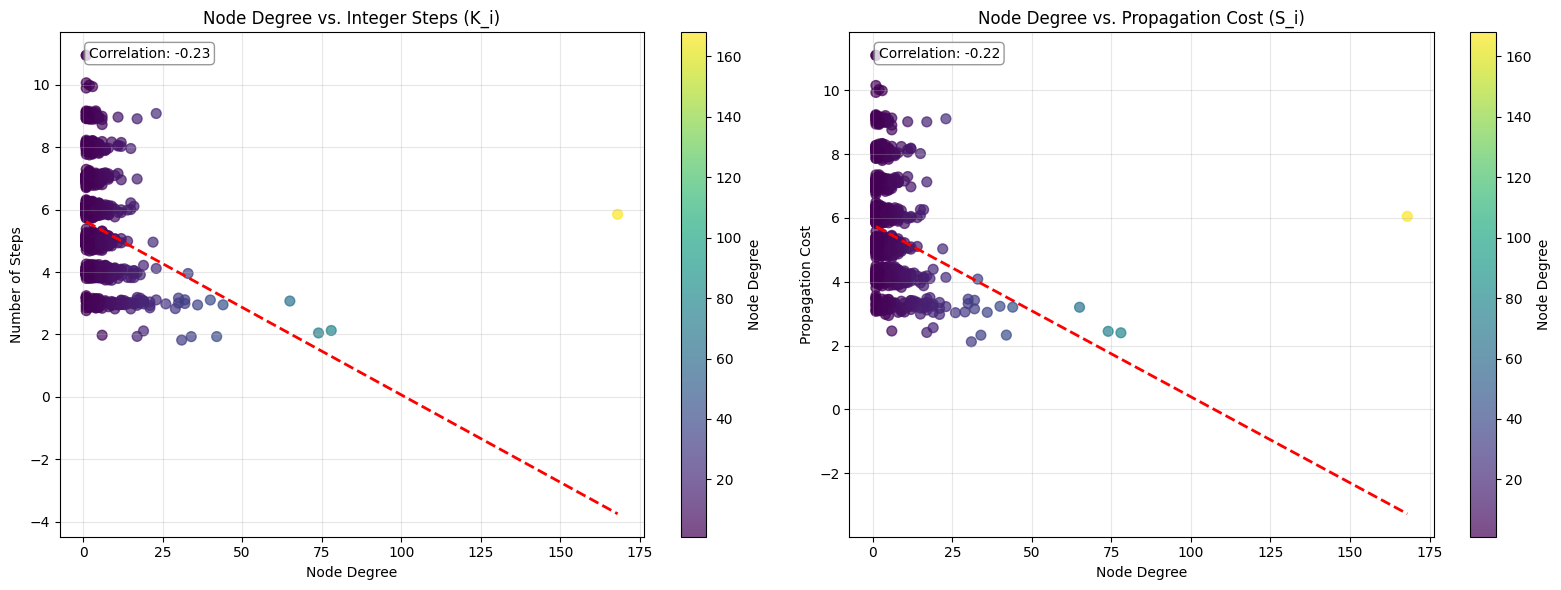

Correlation between node degree and steps: -0.2271
Correlation between node degree and propagation cost: -0.2244


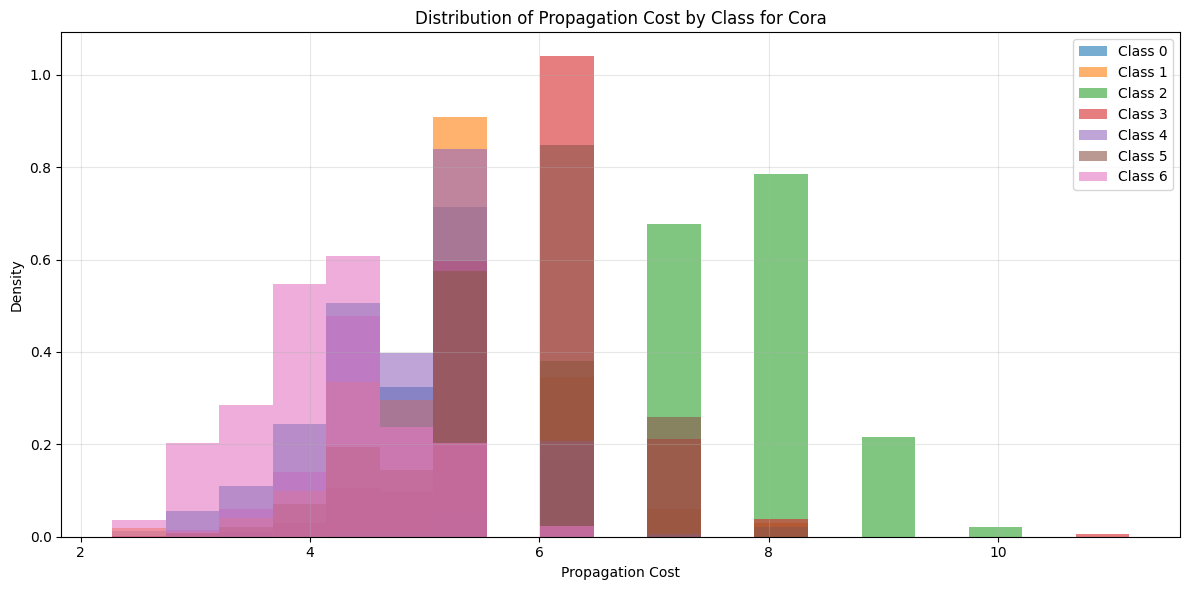

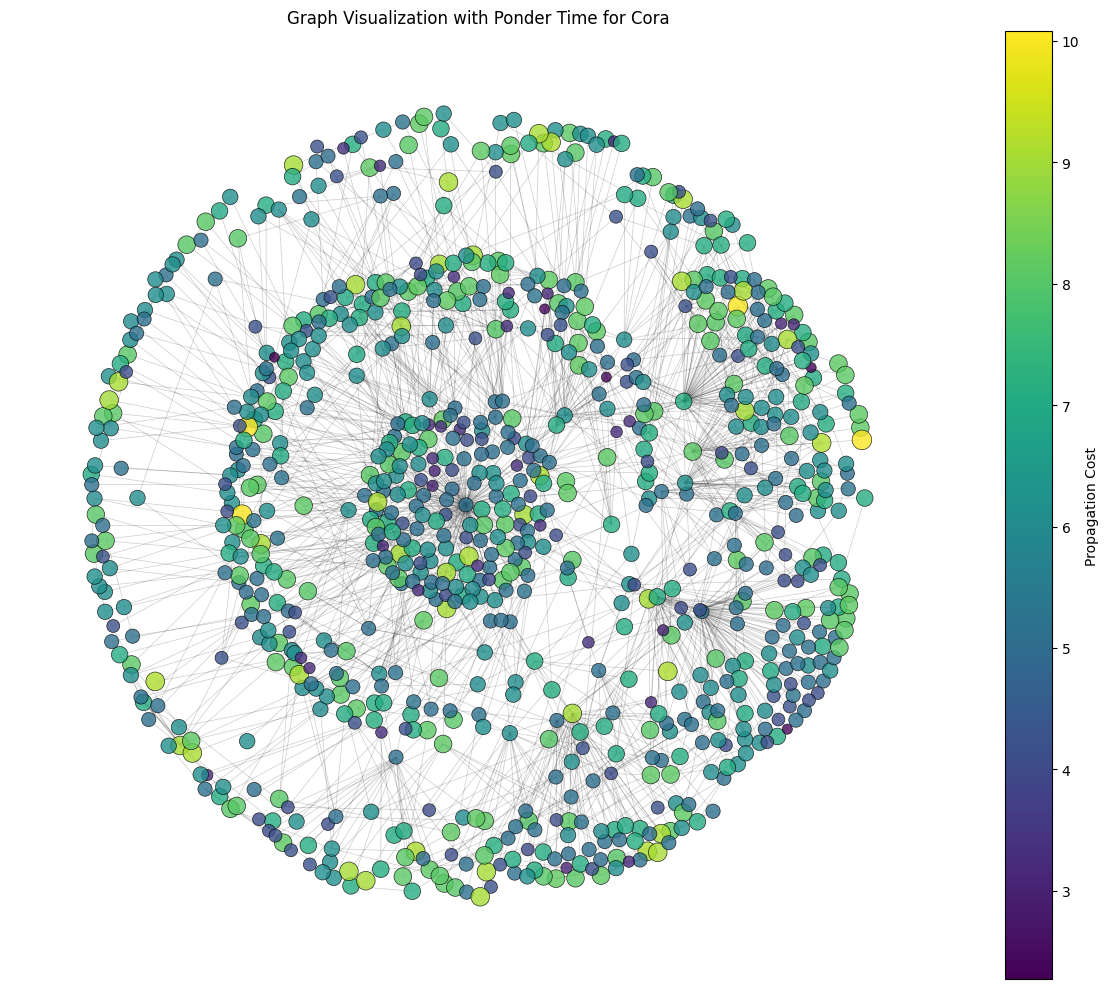

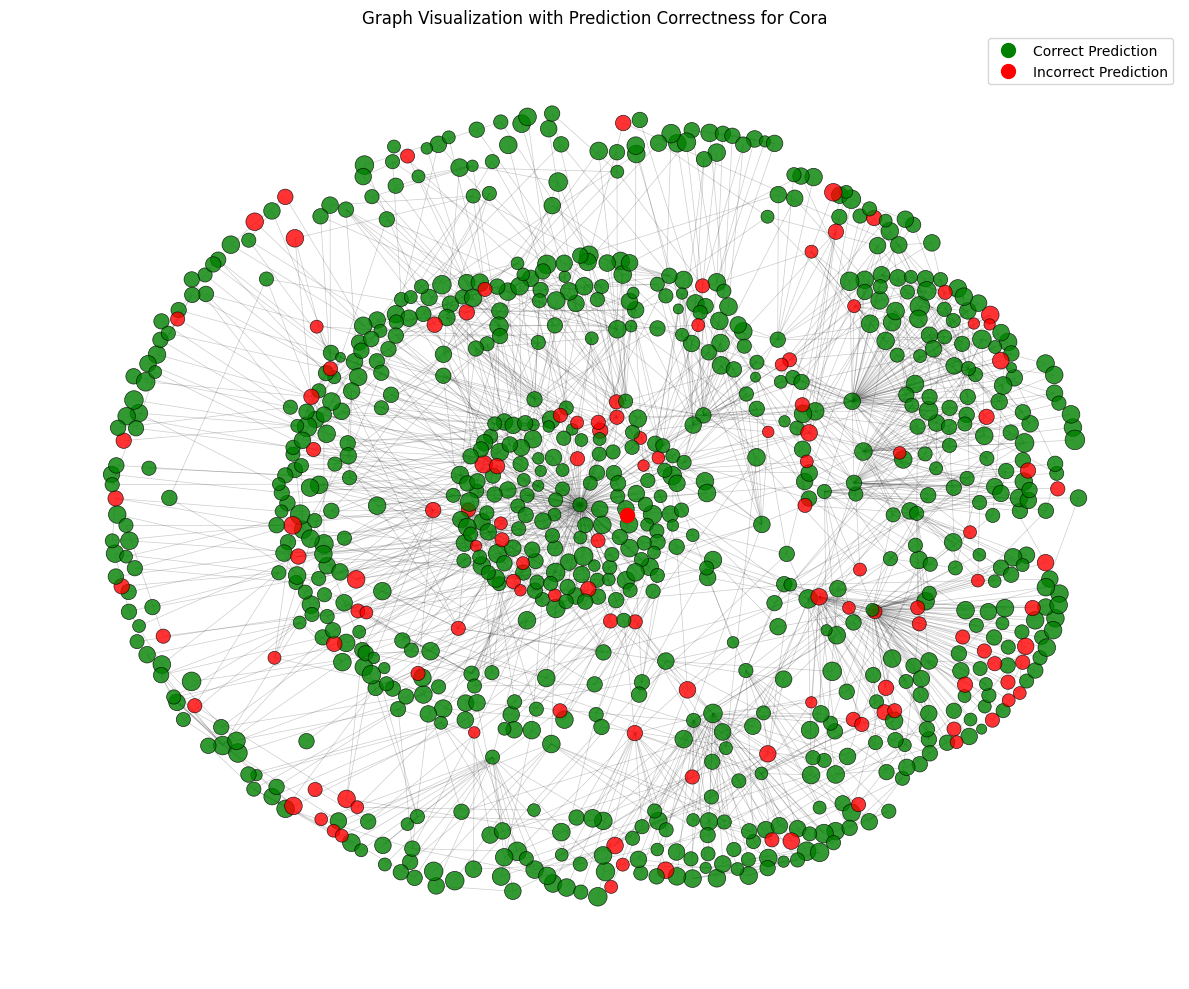

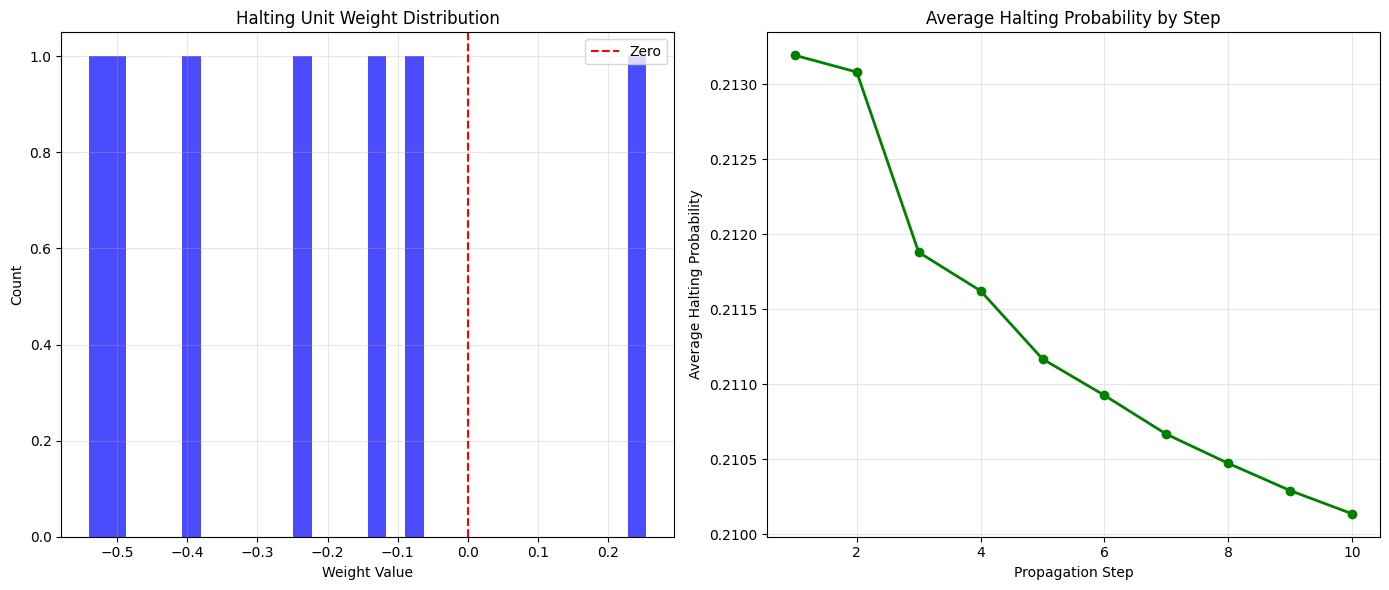

Halting unit bias: -1.8965
Halting unit weights statistics:
  Mean: -0.2294, Std: 0.2595
  Min: -0.5395, Max: 0.2543
Average halting probabilities by step:
  Step 1: 0.2132
  Step 2: 0.2131
  Step 3: 0.2119
  Step 4: 0.2116
  Step 5: 0.2112
  Step 6: 0.2109
  Step 7: 0.2107
  Step 8: 0.2105
  Step 9: 0.2103
  Step 10: 0.2101
Visualizations saved in './visualizations' directory


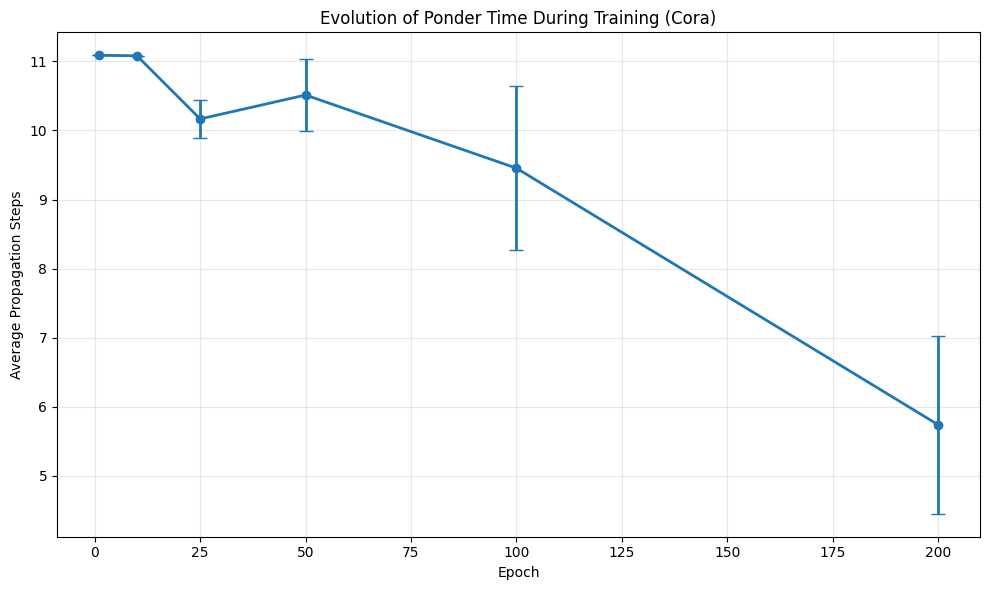

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


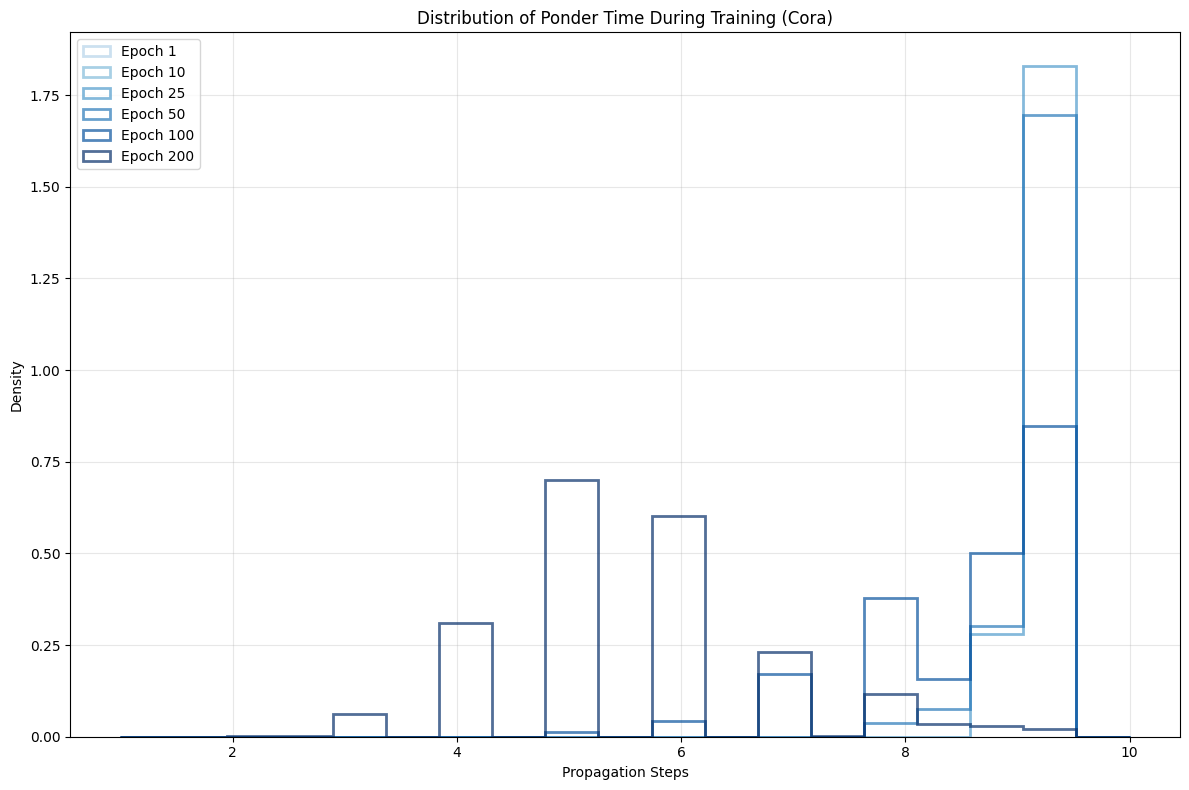

In [17]:
model, data = main("Cora")

## 7. Analyze Results

Let's analyze the results in more detail, especially focusing on the ponder time and its relationship to node properties.

In [33]:
def analyze_node_stats(model, data):
    """detailed statistics about nodes, predictions, and ponder time"""
    model.eval()

    with torch.no_grad():
        # propagation steps
        logits, steps, remainders = model(data)
        prop_cost = steps + remainders

        steps_np = steps.cpu().numpy()
        remainders_np = remainders.cpu().numpy()
        prop_cost_np = prop_cost.cpu().numpy()

        probs = torch.exp(logits)
        confidence = probs.max(dim=1)[0].cpu().numpy() #the highest prob for each node prediction.
        pred = logits.max(1)[1].cpu().numpy() #predicted class label for each node.

        true_labels = data.y.cpu().numpy()
        is_correct = (pred == true_labels)

        node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).cpu().numpy()

        # correlation between the nodes and the diff measures.
        corr_degree_steps = np.corrcoef(node_degrees, steps_np)[0, 1]
        corr_degree_cost = np.corrcoef(node_degrees, prop_cost_np)[0, 1]
        corr_confidence_cost = np.corrcoef(confidence, prop_cost_np)[0, 1]

        print("\nOverall Statistics:")
        print(f"Average steps: {steps_np.mean():.2f} ± {steps_np.std():.2f}")
        print(f"Average remainder: {remainders_np.mean():.2f} ± {remainders_np.std():.2f}")
        print(f"Average propagation cost: {prop_cost_np.mean():.2f} ± {prop_cost_np.std():.2f}")

        print("\nCorrelations:")
        print(f"Correlation between degree and steps: {corr_degree_steps:.4f}")
        print(f"Correlation between degree and propagation cost: {corr_degree_cost:.4f}")
        print(f"Correlation between confidence and propagation cost: {corr_confidence_cost:.4f}")

        # Statistics by class
        print("\nPropagation Cost by Class:")
        # Get number of classes from unique labels instead of data.num_classes
        num_classes = len(np.unique(true_labels))
        for i in range(num_classes):
            class_cost = prop_cost_np[true_labels == i]
            if len(class_cost) > 0:
                print(f"Class {i}: {class_cost.mean():.2f} ± {class_cost.std():.2f}")

        # Statistics by accuracy
        print("\nPropagation Cost by Prediction Correctness:")
        correct_cost = prop_cost_np[is_correct]
        incorrect_cost = prop_cost_np[~is_correct]
        print(f"Correct predictions: {correct_cost.mean():.2f} ± {correct_cost.std():.2f}")
        print(f"Incorrect predictions: {incorrect_cost.mean():.2f} ± {incorrect_cost.std():.2f}")

        # confidence vs. propagation cost
        plt.figure(figsize=(10, 6))
        plt.scatter(prop_cost_np[is_correct], confidence[is_correct],
                   color='green', alpha=0.6, label='Correct Predictions')
        plt.scatter(prop_cost_np[~is_correct], confidence[~is_correct],
                   color='red', alpha=0.6, label='Incorrect Predictions')

        # trend line
        z = np.polyfit(prop_cost_np, confidence, 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(prop_cost_np), max(prop_cost_np), 100)
        plt.plot(x_range, p(x_range), 'b--', linewidth=2)

        plt.title('Prediction Confidence vs. Propagation Cost')
        plt.xlabel('Propagation Cost')
        plt.ylabel('Prediction Confidence')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'./visualizations/confidence_vs_cost.png', dpi=300)
        plt.show()


Overall Statistics:
Average steps: 7.98 ± 1.22
Average remainder: 0.08 ± 0.04
Average propagation cost: 8.05 ± 1.20

Correlations:
Correlation between degree and steps: 0.0885
Correlation between degree and propagation cost: 0.0902
Correlation between confidence and propagation cost: -0.0895

Propagation Cost by Class:
Class 0: 7.60 ± 0.82
Class 1: 8.32 ± 0.89
Class 2: 9.21 ± 0.85
Class 3: 8.55 ± 0.79
Class 4: 6.57 ± 0.73
Class 5: 7.50 ± 0.73

Propagation Cost by Prediction Correctness:
Correct predictions: 8.06 ± 1.27
Incorrect predictions: 8.03 ± 1.03


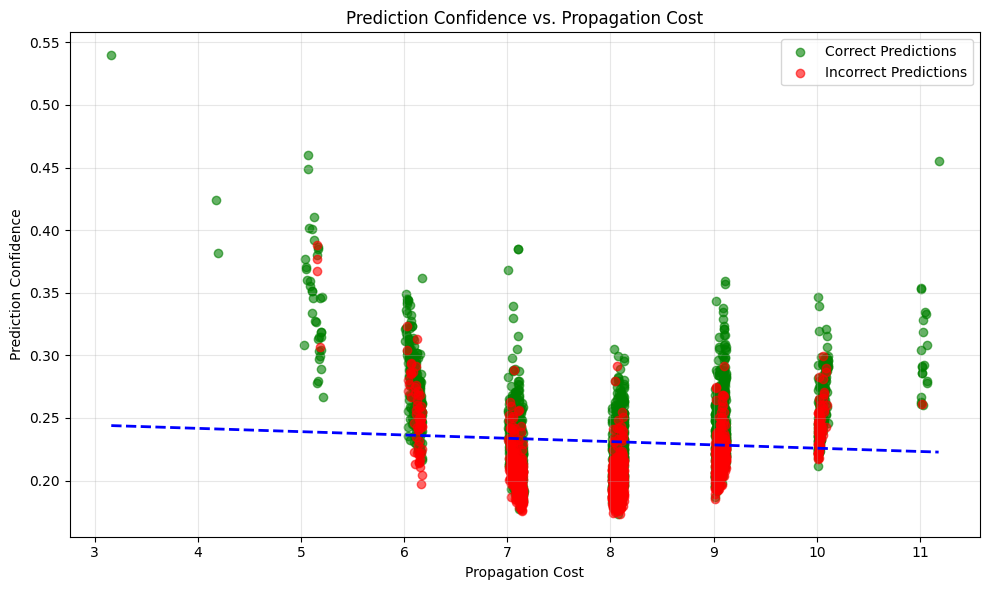

In [34]:
# node lvl statistics
analyze_node_stats(model, data)

## 9. Different Alpha Values - UNFINISHED.


## some findings between paper main idea and the authors techniques

**Adaptive Propagation Mechanism**:
   - Each node independently determines its optimal number of propagation steps
   - The halting unit learns when each node has received sufficient information
   - The algorithm carefully tracks and updates the halting state for each node

**Authors' Special Techniques**:
   - Special bias initialization for the halting unit to encourage longer paths initially
   - Edge dropout for better regularization
   - Selective parameter regularization (separate reg_params and non_reg_params)
   - Alternating optimization strategy for halting unit parameters
   - Propagation penalty applied only to training nodes

